# 读取数据并进行送入模型前准备

In [1]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 加载数据并进行表连接

In [2]:
DATA_DIR = '../data/'

# 从文件中导入数据到dataframe中
def get_df(file, header=None):
    df = pd.read_csv(file, header=None)
    # df.columns = DF_HEADER.get(key, df.columns)
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

dfjob = get_df(DATA_DIR + 'pai_job_table.csv')
dftask = get_df(DATA_DIR + 'pai_task_table.csv')
dfinstance = get_df(DATA_DIR + 'pai_instance_table.csv')
dfsensor = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfgroup = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp_spec = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm_metric = get_df(DATA_DIR + 'pai_machine_metric.csv')

In [3]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dftask, dfjob, dfinstance, dfgroup)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


In [4]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfinstance, dftask, dfgroup)

dfi + dft ...
dfi + dft + dfg ...


In [5]:
dfws = dfw.merge(dfp_spec.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfsensor.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')

In [6]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])

## 按照模型要求调整Dataframe

#### 生成每分钟作业提交数的Dataframe

In [7]:
# 生成 min 列表示时间顺序
dfa['minofyear'] = dfa.start_date.apply(lambda c: (c.dayofyear * 24)*60 + (c.hour)*60 + c.minute)
# 按照分钟进行聚合 统计job的数量
df_job_of_min = dfa.groupby('minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
df_job_of_min.sort_values("minofyear", inplace=True)

In [8]:
df_job_of_min.head()

,minofyear,job_name
0,10158.0,2
1,10520.0,2
2,10594.0,2
3,10782.0,2
4,10800.0,1


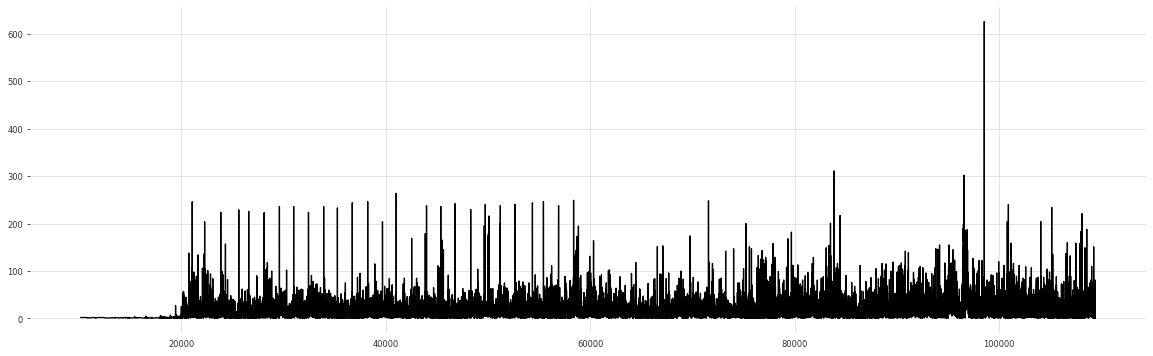

In [9]:

plt.figure(figsize=(20, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(df_job_of_min.minofyear, df_job_of_min.job_name)

在时间点20000后产生规律性，因此进行截取，用20000之后的数据

In [10]:
# 寻找第一个 天单位整点整分钟 进行数据截取 
# 根据上图显示 20000 之前的点感觉不连续
# 直接在 20000 分钟之后的第一个点取样
df_job_of_min = df_job_of_min[(df_job_of_min.minofyear>=20160)].set_index('minofyear')[['job_name']]
# 再将 index 进行转换
df_job_of_min = df_job_of_min.reset_index()

In [11]:
df_job_of_min.head()

,minofyear,job_name
0,20160.0,6
1,20161.0,7
2,20162.0,12
3,20163.0,3
4,20164.0,52


#### 生成每10分钟作业提交数的Dataframe

In [12]:
# 以10分钟为单位统计
df_minofyear_notnoll = dfa.dropna(subset=['minofyear'])
df_minofyear_notnoll['10minofyear'] =  df_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)
dftcc_10min = df_minofyear_notnoll.groupby('10minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
dftcc_10min.sort_values("10minofyear", inplace=True)

C:\Users\liduo\AppData\Local\Temp\ipykernel_1852\3641705392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minofyear_notnoll['10minofyear'] =  df_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)


In [13]:
dftcc_10min.head()

,10minofyear,job_name
0,10150,2
1,10520,2
2,10590,2
3,10780,2
4,10800,1


同样选取20000以后的

In [14]:
dft_job_of_10min = dftcc_10min[(dftcc_10min['10minofyear']>=20160)].set_index('10minofyear')[['job_name']]
# 再将 index 进行转换
dft_job_of_10min = dft_job_of_10min.reset_index()

In [15]:
dft_job_of_10min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   10minofyear  8928 non-null   int64
 1   job_name     8928 non-null   int64
dtypes: int64(2)
memory usage: 139.6 KB


In [16]:
dft_job_of_10min.head()

,10minofyear,job_name
0,20160,148
1,20170,168
2,20180,87
3,20190,206
4,20200,205


# 对 df_job_of_year进行截取 截取第n天的

#### 处理时间戳
1. 先统一化为从0开始
2. 然后以天为单位进行分割

In [17]:
dft_job_of_10min['10minofyear'] = dft_job_of_10min['10minofyear'].apply(lambda x: int(x-20160))
df_job_of_min['minofyear'] = df_job_of_min['minofyear'].apply(lambda x: int(x-20160))

In [18]:
df_job_of_min, dft_job_of_10min

(       minofyear  job_name
 0              0         6
 1              1         7
 2              2        12
 3              3         3
 4              4        52
 ...          ...       ...
 88356      89273         5
 88357      89274         2
 88358      89275         3
 88359      89276         2
 88360      89278         1
 
 [88361 rows x 2 columns],
       10minofyear  job_name
 0               0       148
 1              10       168
 2              20        87
 3              30       206
 4              40       205
 ...           ...       ...
 8923        89230       149
 8924        89240        83
 8925        89250        46
 8926        89260        95
 8927        89270        43
 
 [8928 rows x 2 columns])

#### 截取前i天的

In [19]:
def before_nday_min(nday, df):
    return df.loc[df['minofyear']<=nday*24*60]

def before_nday_10min(nday, df):
    return df.loc[df['10minofyear']<=nday*24*60]

#### 截取第i天的

In [20]:
def n_day_min(nday, df):
    time_end = 60*24*nday
    if (nday==1) :
        return df.loc[df['minofyear']<=1440]
    else :
        return df.loc[(df['minofyear']<=time_end)&(df['minofyear']>=(time_end-1440))]

def n_day_10min(nday, df):
    time_end = 60*24*nday
    if (nday==1) :
        return df.loc[df['10minofyear']<=1440]
    else :
        return df.loc[(df['10minofyear']<=time_end)&(df['10minofyear']>=(time_end-1440))]



In [21]:
df_min1 = n_day_min(1, df_job_of_min)
df_10min1 = n_day_10min(1, dft_job_of_10min)

In [22]:
df_min1.info(), df_10min1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429 entries, 0 to 1428
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   minofyear  1429 non-null   int64
 1   job_name   1429 non-null   int64
dtypes: int64(2)
memory usage: 33.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   10minofyear  145 non-null    int64
 1   job_name     145 non-null    int64
dtypes: int64(2)
memory usage: 3.4 KB


(None, None)

In [23]:
df_min2 = n_day_min(2, df_job_of_min)
df_10min2 = n_day_10min(2, dft_job_of_10min)

In [24]:
df_10min2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 144 to 288
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   10minofyear  145 non-null    int64
 1   job_name     145 non-null    int64
dtypes: int64(2)
memory usage: 3.4 KB


#### 增加时间戳

In [25]:
# 添加时间索引
# 假设在今年1月1日开始
df_min1["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_min1.minofyear, "m")
df_10min1["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_10min1['10minofyear'], "m")

C:\Users\liduo\AppData\Local\Temp\ipykernel_1852\1158539614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min1["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_min1.minofyear, "m")
C:\Users\liduo\AppData\Local\Temp\ipykernel_1852\1158539614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10min1["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_10min1['10minofyear'], "m")


In [26]:
df_min1, df_10min1

(      minofyear  job_name                date
 0             0         6 2022-01-01 00:00:00
 1             1         7 2022-01-01 00:01:00
 2             2        12 2022-01-01 00:02:00
 3             3         3 2022-01-01 00:03:00
 4             4        52 2022-01-01 00:04:00
 ...         ...       ...                 ...
 1424       1436         1 2022-01-01 23:56:00
 1425       1437         3 2022-01-01 23:57:00
 1426       1438         7 2022-01-01 23:58:00
 1427       1439         5 2022-01-01 23:59:00
 1428       1440         8 2022-01-02 00:00:00
 
 [1429 rows x 3 columns],
      10minofyear  job_name                date
 0              0       148 2022-01-01 00:00:00
 1             10       168 2022-01-01 00:10:00
 2             20        87 2022-01-01 00:20:00
 3             30       206 2022-01-01 00:30:00
 4             40       205 2022-01-01 00:40:00
 ..           ...       ...                 ...
 140         1400       114 2022-01-01 23:20:00
 141         1410       

# 准备训练以及训练和验证

In [27]:
df_min1.describe()

,minofyear,job_name
count,1429.00000,1429.000000
mean,723.83485,12.894332
std,415.68472,12.447904
min,0.00000,1.000000
25%,368.00000,7.000000
50%,726.00000,11.000000
75%,1083.00000,16.000000
max,1440.00000,246.000000


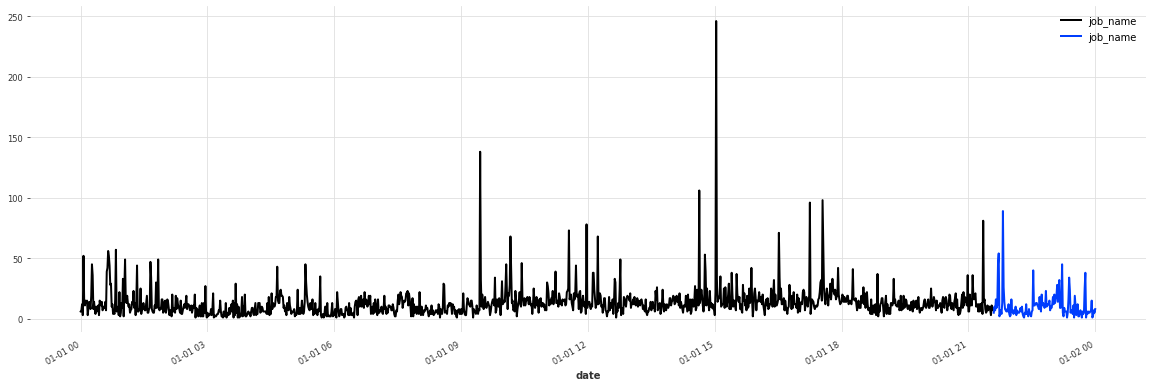

In [28]:
import darts
from darts import TimeSeries

df_min1_ds = df_min1.drop(columns=['minofyear'])
dataset_min1 = TimeSeries.from_dataframe(
    df_min1_ds,
    time_col='date',
    value_cols='job_name',
    fill_missing_dates=True,
    fillna_value=13, # 用均值进行填充
)

# 划分训练集和测试集
train_min1, val_min1 = dataset_min1.split_before(0.9)
plt.figure(figsize=(20, 6))
train_min1.plot()
val_min1.plot()


#### 自相关性和偏自相关分析

In [52]:
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf
check_seasonality(train_min1, alpha=0.05)

(True, 3)

In [29]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=60, output_chunk_length=15, random_state=42)

model.fit([train_min1], epochs=200, verbose=True)

[2022-06-16 15:25:56,070] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
2022-06-16 15:25:56 darts.models WARNING: Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
[2022-06-16 15:26:00,309] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1222 samples.
[2022-06-16 15:26:00,309] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1222 samples.
2022-06-16 15:26:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1222 samples.
[2022-06-16 15:26:00,396] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-16 15:26:00,396] INFO | darts.models.forecasting.torch_forecasting_model | Time series v

Training: 0it [00:00, ?it/s]

Predicting: 39it [00:00, ?it/s]

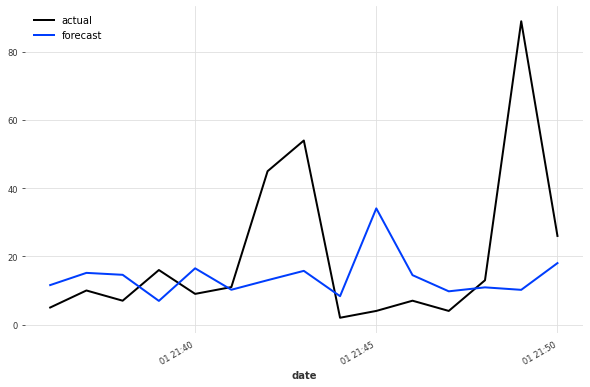

In [37]:
pred = model.predict(series=train_min1, n=15)

plt.figure(figsize=(10, 6))
val_min1.head(15).plot(label="actual")
pred.plot(label="forecast")

#### df10min1

In [69]:
df_10min1.describe()

,10minofyear,job_name
count,145.000000,145.000000
mean,720.000000,127.737931
std,420.019841,56.818671
min,0.000000,22.000000
25%,360.000000,87.000000
50%,720.000000,122.000000
75%,1080.000000,157.000000
max,1440.000000,416.000000


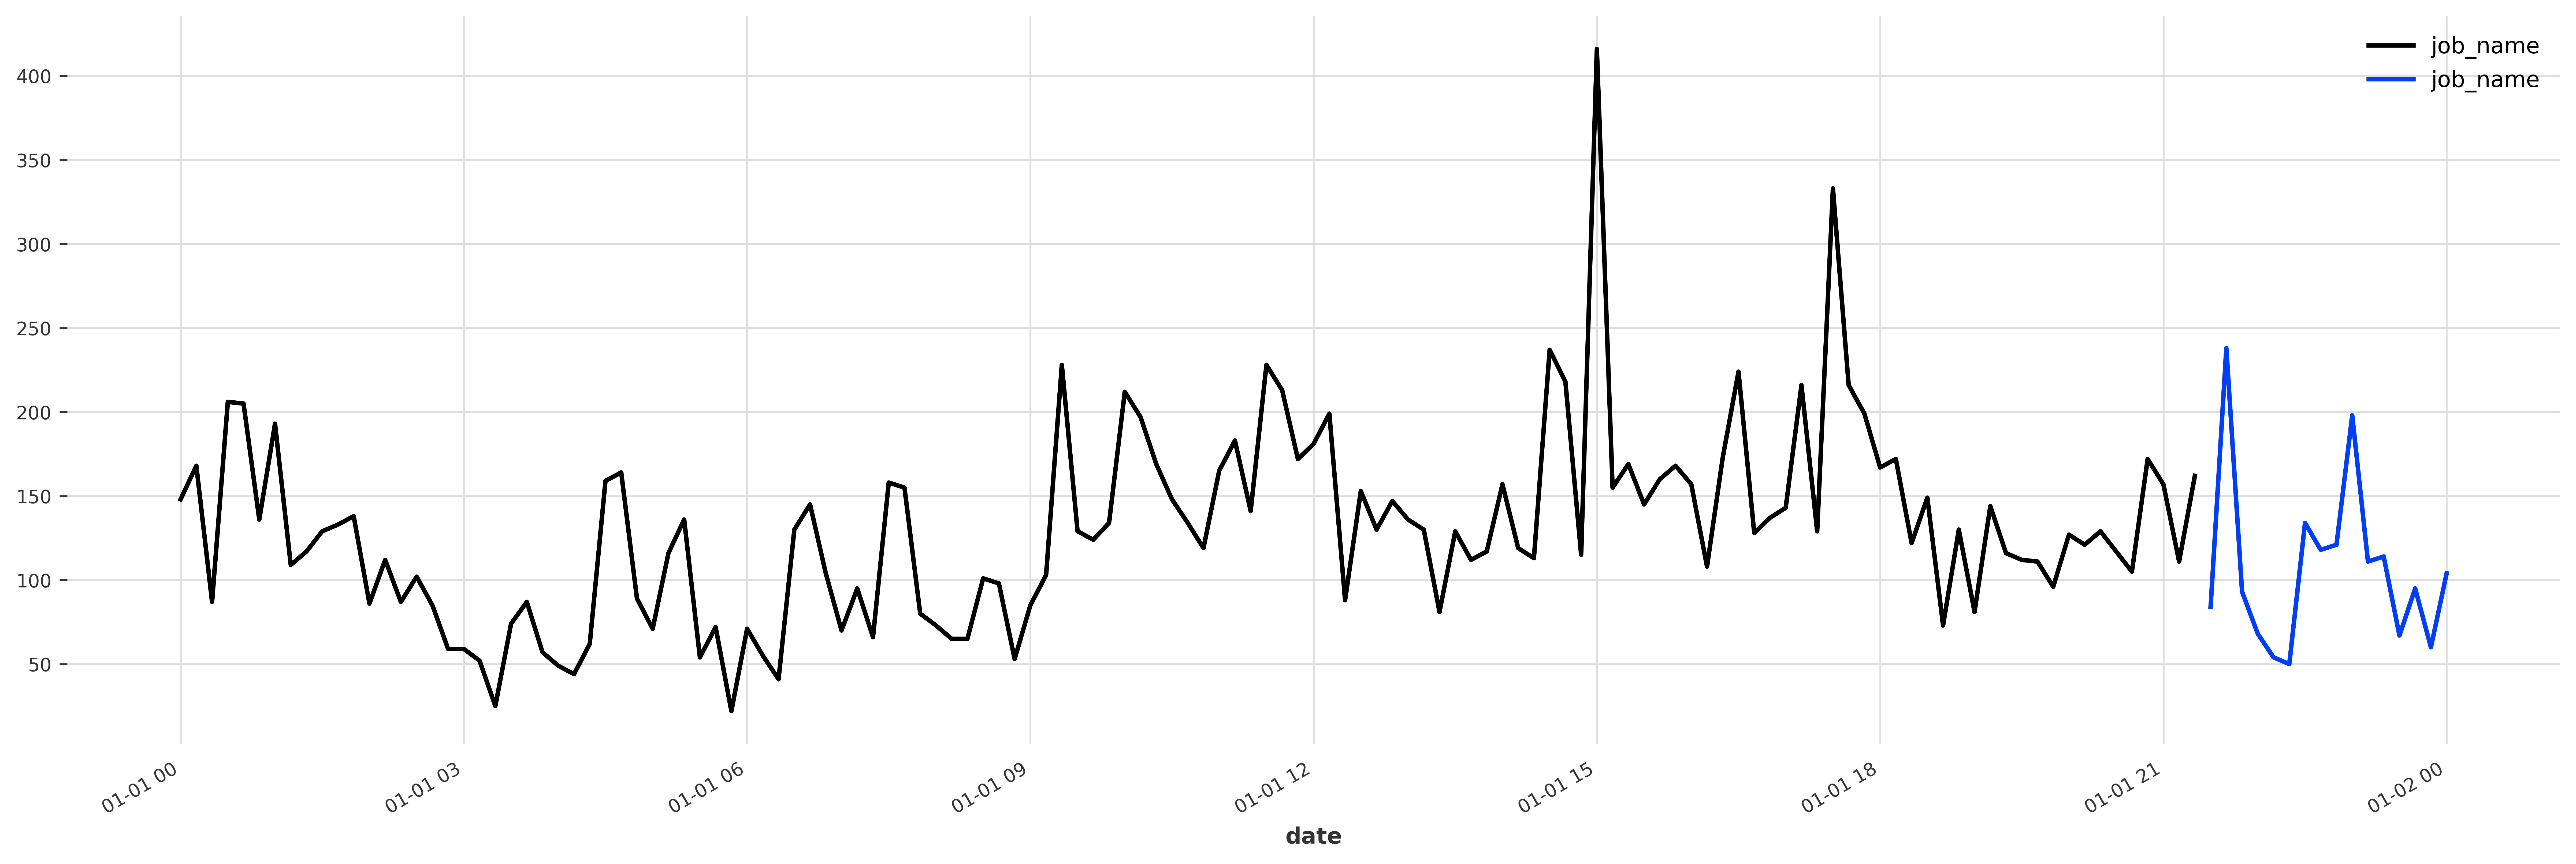

In [70]:
import darts
from darts import TimeSeries

df_10min1_ds = df_10min1.drop(columns=['10minofyear'])
dataset_10min1 = TimeSeries.from_dataframe(
    df_10min1_ds,
    time_col='date',
    value_cols='job_name',
    fill_missing_dates=True,
    fillna_value=128, # 用均值进行填充
)

# 划分训练集和测试集
train_10min1, val_10min1 = dataset_10min1.split_before(0.9)
plt.figure(figsize=(20, 6), dpi=600)
train_10min1.plot()
val_10min1.plot()

In [71]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=20, output_chunk_length=2, random_state=42)

model.fit([train_10min1], epochs=50, verbose=True)

[2022-06-15 16:19:46,547] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 108 samples.
[2022-06-15 16:19:46,547] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 108 samples.
2022-06-15 16:19:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 108 samples.
[2022-06-15 16:19:46,626] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-15 16:19:46,626] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-15 16:19:46 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-15 16:19:46,628] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

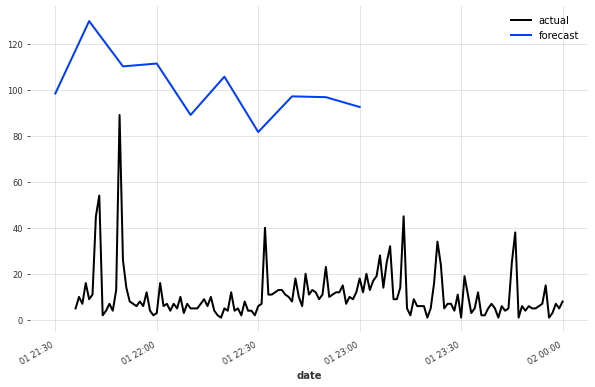

In [74]:
pred = model.predict(series=train_10min1, n=10)

plt.figure(figsize=(10, 6))
val_min1.plot(label="actual")
pred.plot(label="forecast")

## 用一周的数据进行训练

In [128]:
df_job_of_min7 = before_nday_min(7, df_job_of_min)
df_job_of_min7["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_job_of_min7['minofyear'], "m")

C:\Users\liduo\AppData\Local\Temp\ipykernel_1852\3980277810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_of_min7["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_job_of_min7['minofyear'], "m")


In [90]:
df_job_of_min7

,minofyear,job_name,date
0,0,6,2022-01-01 00:00:00
1,1,7,2022-01-01 00:01:00
2,2,12,2022-01-01 00:02:00
3,3,3,2022-01-01 00:03:00
4,4,52,2022-01-01 00:04:00
...,...,...,...
9965,10076,12,2022-01-07 23:56:00
9966,10077,1,2022-01-07 23:57:00
9967,10078,6,2022-01-07 23:58:00
9968,10079,3,2022-01-07 23:59:00


In [89]:
df_job_of_min7.describe()

,minofyear,job_name
count,9970.000000,9970.000000
mean,5039.439218,12.139418
std,2915.530869,12.356039
min,0.000000,1.000000
25%,2510.250000,6.000000
50%,5025.500000,9.000000
75%,7578.750000,15.000000
max,10080.000000,246.000000


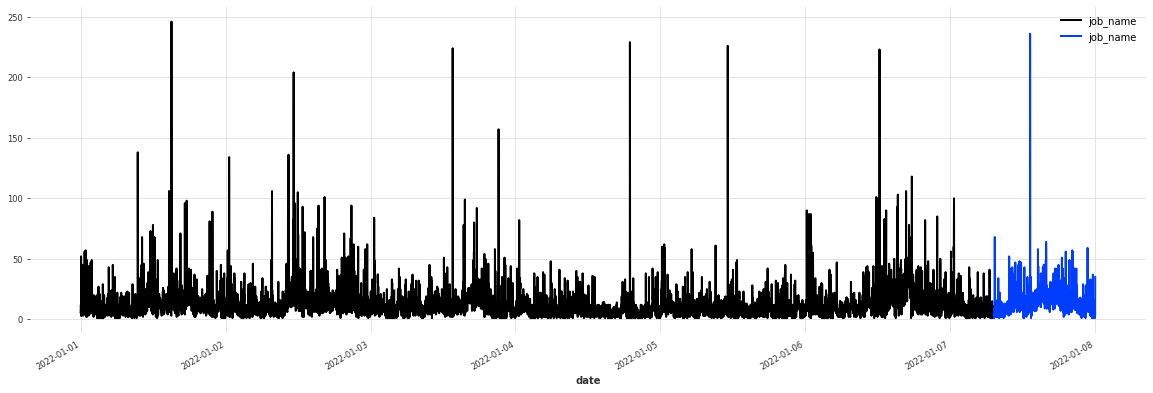

In [91]:
import darts
from darts import TimeSeries

df_min7 = df_job_of_min7.drop(columns=['minofyear'])
dataset_min7 = TimeSeries.from_dataframe(
    df_min7,
    time_col='date',
    value_cols='job_name',
    fill_missing_dates=True,
    freq='T',
    fillna_value=12, # 用均值进行填充
)

# 划分训练集和测试集
train_min7, val_min7 = dataset_min7.split_before(0.9)
plt.figure(figsize=(20, 6))
train_min7.plot()
val_min7.plot()

In [99]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=60, output_chunk_length=20, random_state=42)

model.fit([train_min7], epochs=50, verbose=True)

[2022-06-15 21:51:07,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 8993 samples.
[2022-06-15 21:51:07,224] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 8993 samples.
2022-06-15 21:51:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 8993 samples.
[2022-06-15 21:51:07,313] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-15 21:51:07,313] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-15 21:51:07 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-15 21:51:07,316] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Training: 0it [00:00, ?it/s]

d:\Coding\Python\python39\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Predicting: 276it [00:00, ?it/s]

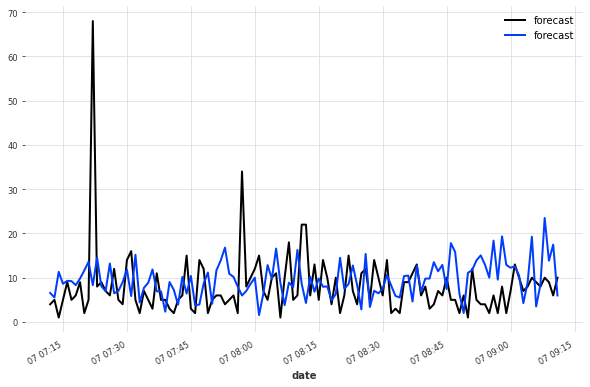

In [98]:
pred = model.predict(series=train_min7, n=120)

plt.figure(figsize=(10, 6))
val_plt = val_min7.head(120)
val_plt.plot(label='forecast' )
# val_min7.plot(label="actual")
pred.plot(label="forecast")

## 用60天数据训练

In [129]:
df_job_of_min60 = before_nday_min(7, df_job_of_min)
df_job_of_min60["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_job_of_min60['minofyear'], "m")

C:\Users\liduo\AppData\Local\Temp\ipykernel_1852\1595226430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_of_min60["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(df_job_of_min60['minofyear'], "m")


In [62]:
df_job_of_min60

,minofyear,job_name,date
0,0,6,2022-01-01 00:00:00
1,1,7,2022-01-01 00:01:00
2,2,12,2022-01-01 00:02:00
3,3,3,2022-01-01 00:03:00
4,4,52,2022-01-01 00:04:00
...,...,...,...
9965,10076,12,2022-01-07 23:56:00
9966,10077,1,2022-01-07 23:57:00
9967,10078,6,2022-01-07 23:58:00
9968,10079,3,2022-01-07 23:59:00


In [63]:
df_job_of_min60.describe()

,minofyear,job_name
count,9970.000000,9970.000000
mean,5039.439218,12.139418
std,2915.530869,12.356039
min,0.000000,1.000000
25%,2510.250000,6.000000
50%,5025.500000,9.000000
75%,7578.750000,15.000000
max,10080.000000,246.000000


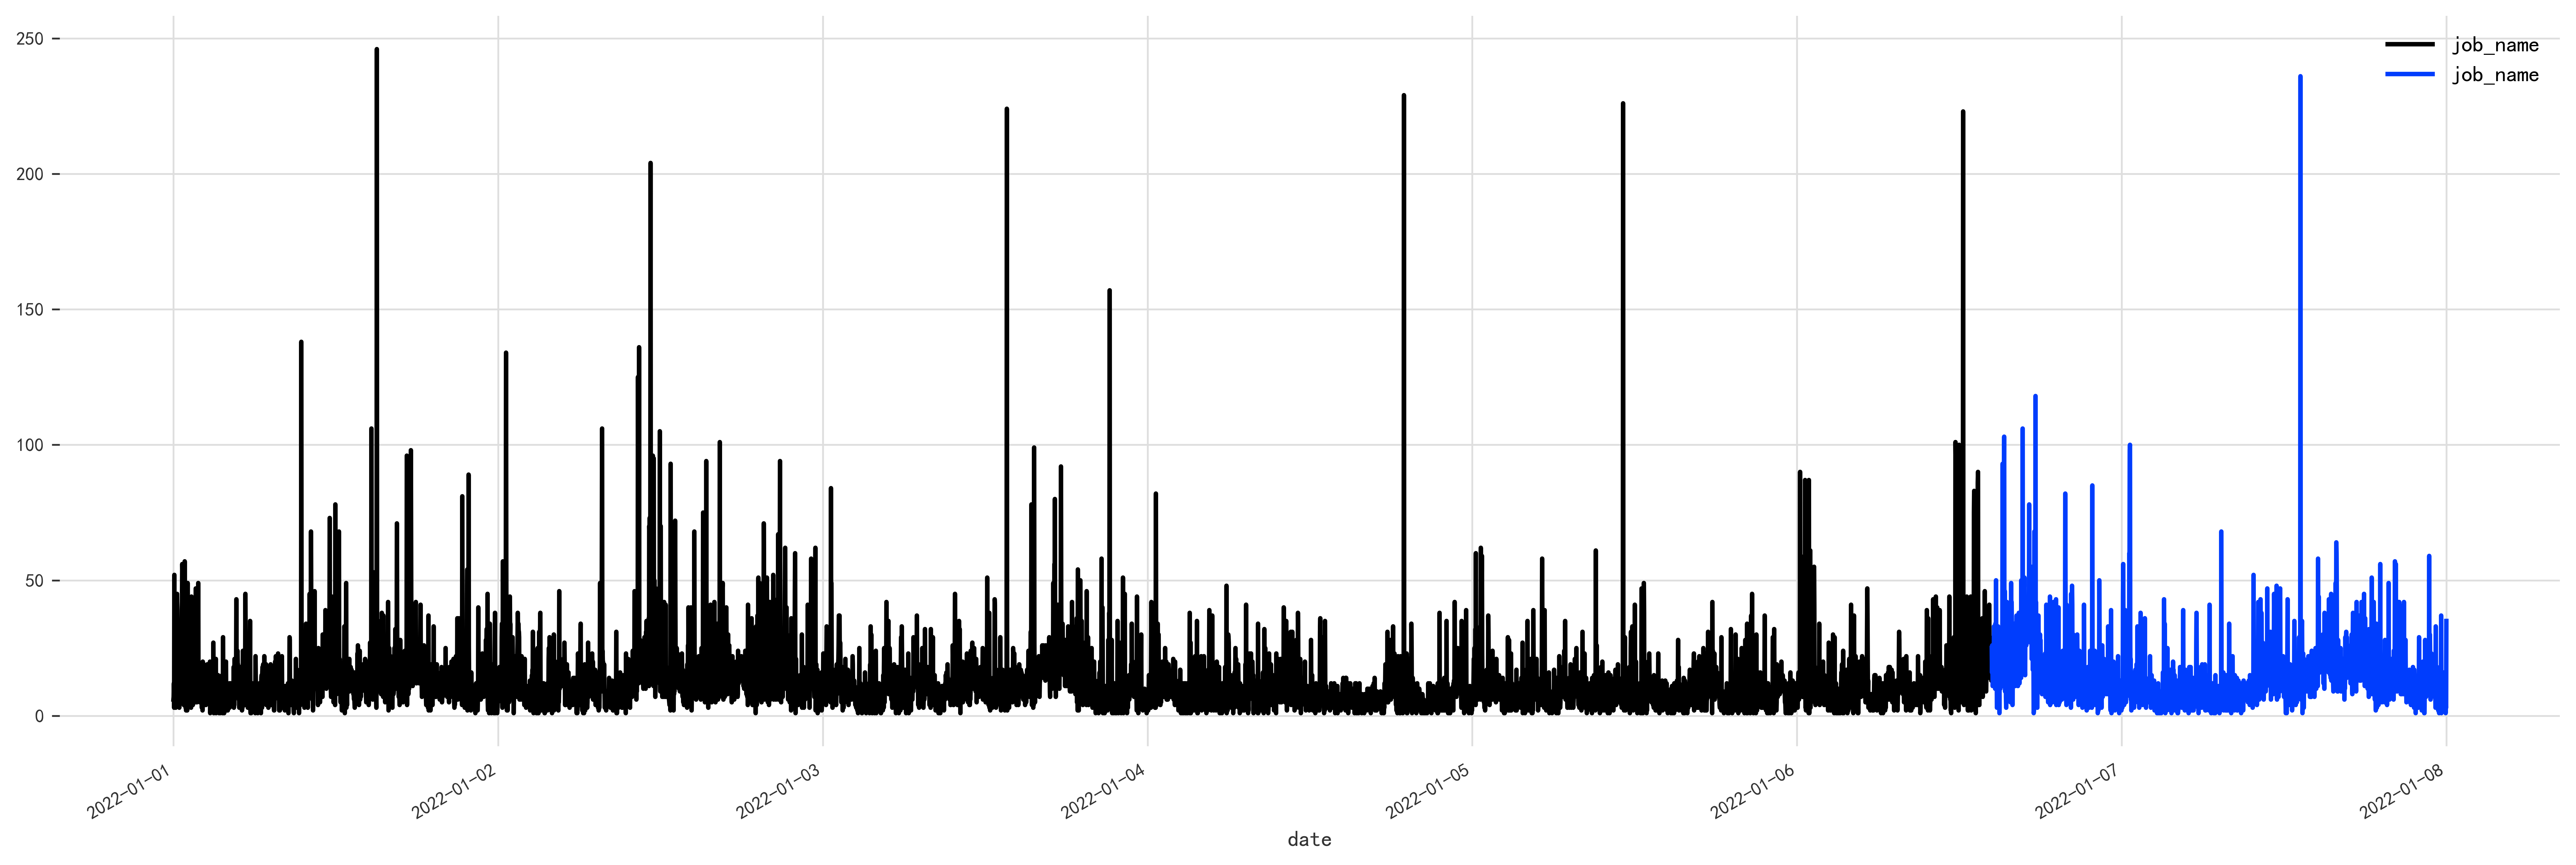

In [130]:
import darts
from darts import TimeSeries

df_min60 = df_job_of_min60.drop(columns=['minofyear'])
dataset_min60 = TimeSeries.from_dataframe(
    df_min60,
    time_col='date',
    value_cols='job_name',
    fill_missing_dates=True,
    freq='T',
    fillna_value=12, # 用均值进行填充
)

# 划分训练集和测试集
train_min60, val_min60 = dataset_min60.split_before(0.8)
plt.figure(figsize=(20, 6))
train_min60.plot()
val_min60.plot()

In [46]:
check_seasonality(dataset_min60, m=(24*60*60), max_lag=(25*60))

(True, 1440)

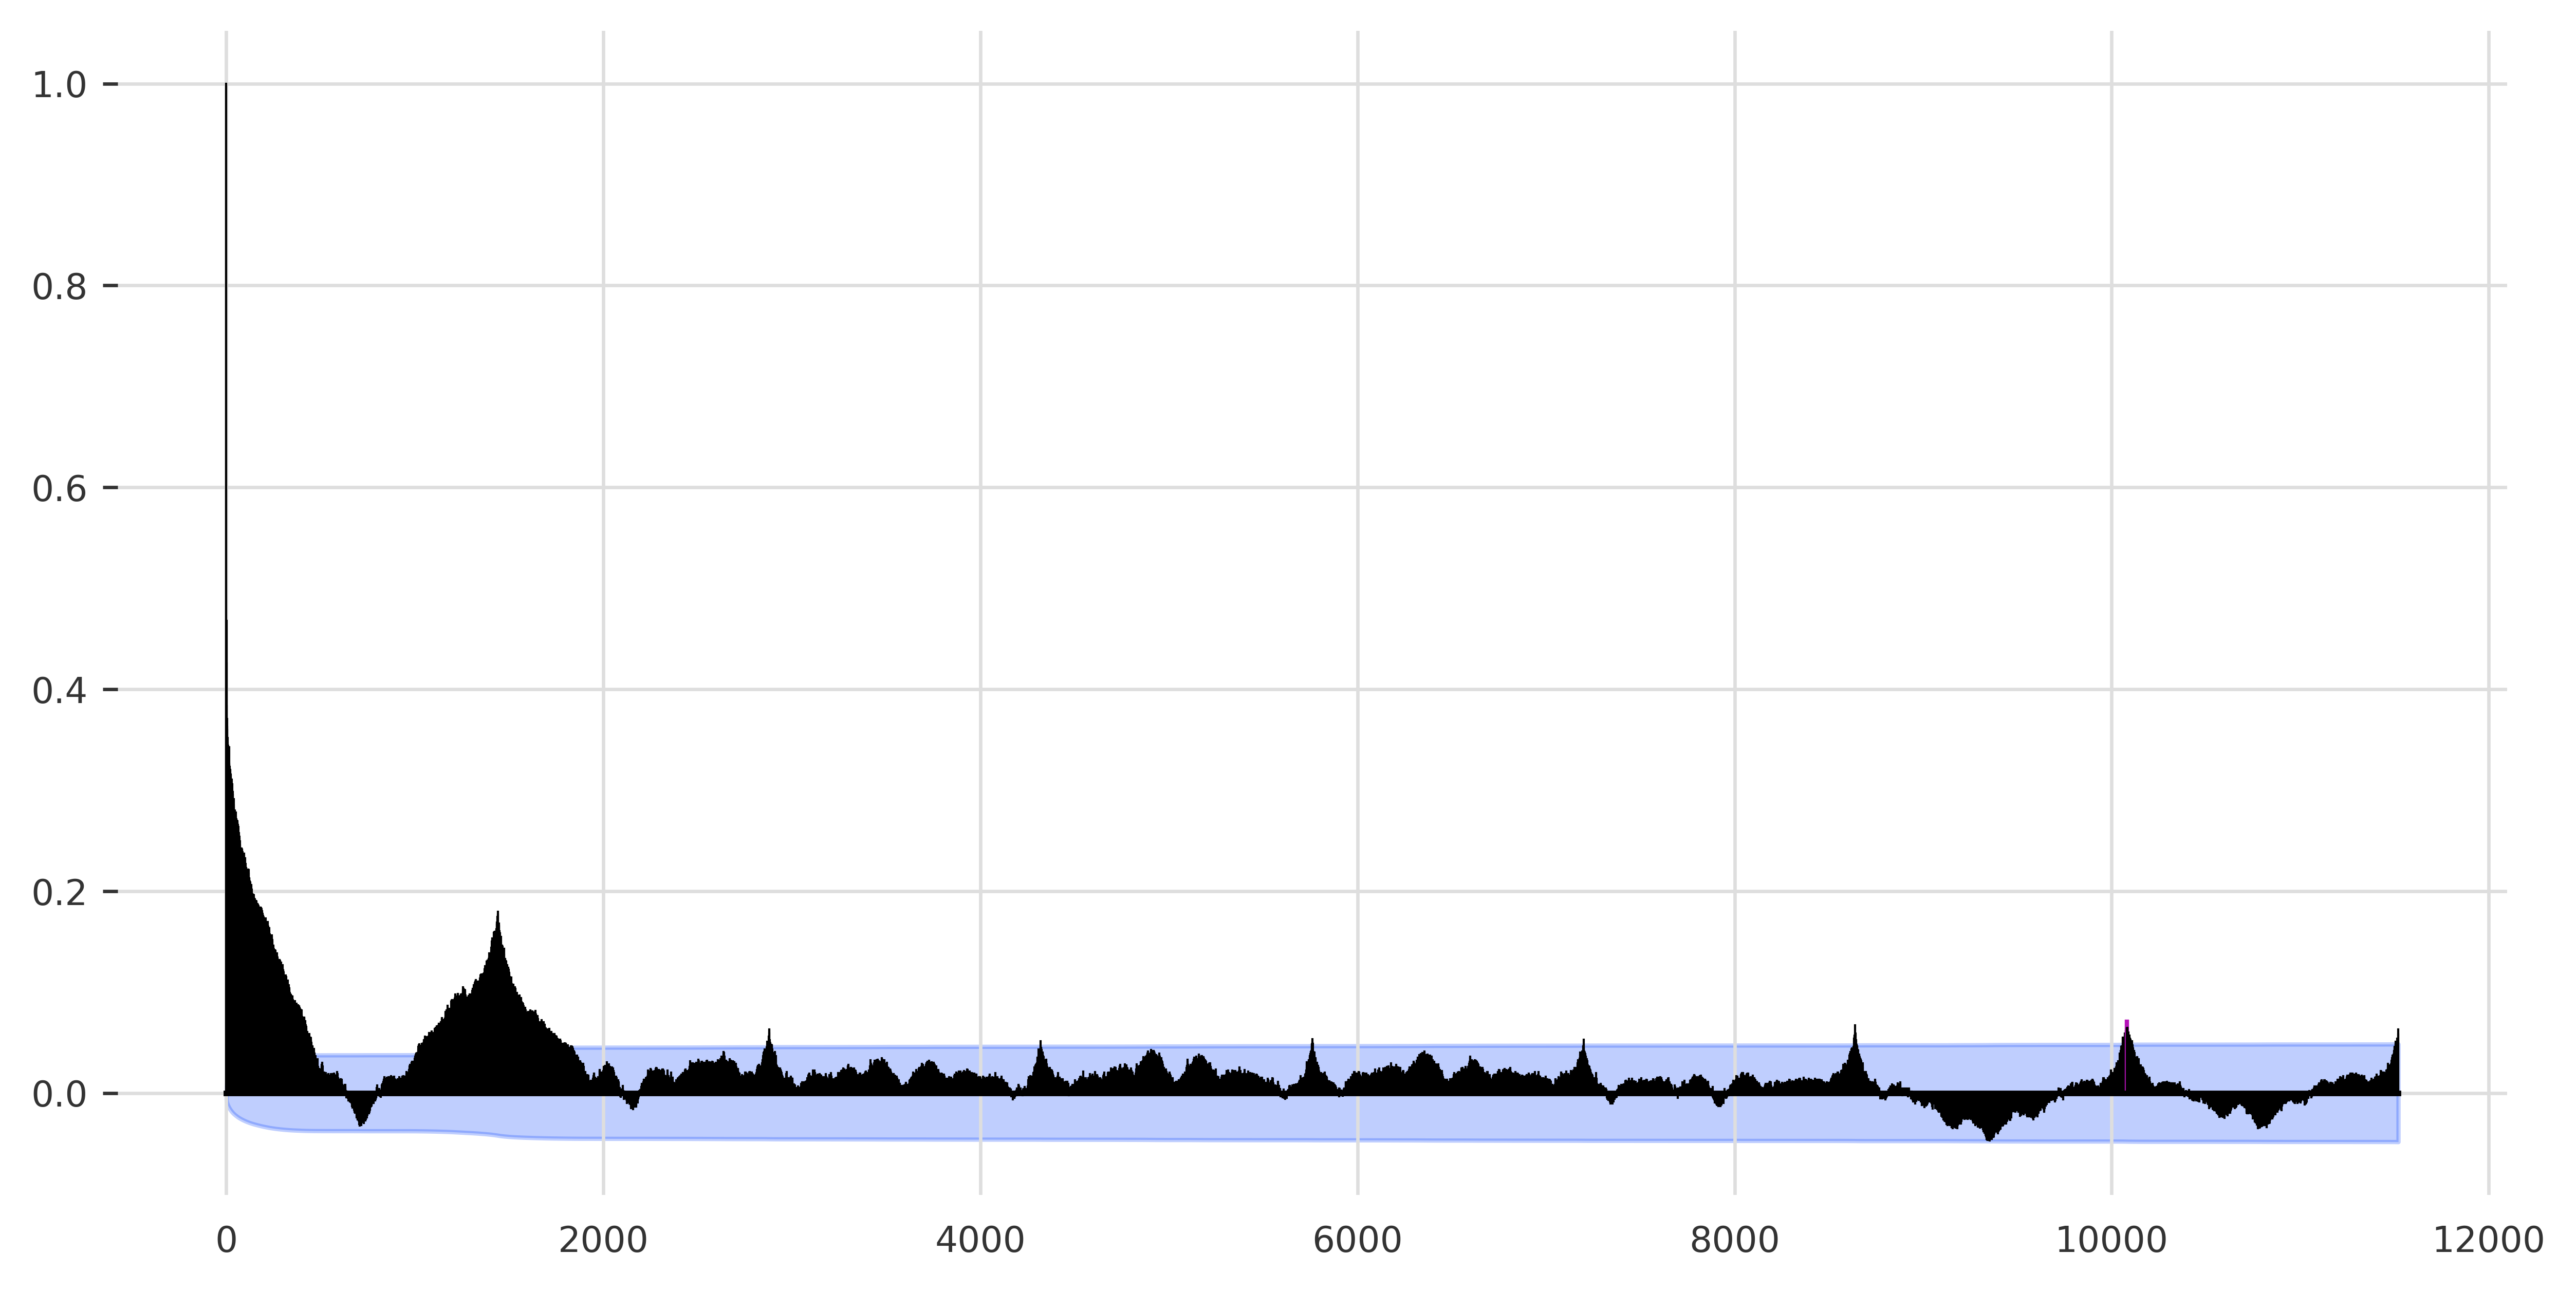

In [51]:
plt.rcParams['figure.dpi'] = 600
plot_acf(dataset_min60, m=(24*60*7), max_lag=(24*60*8),alpha=0.05)

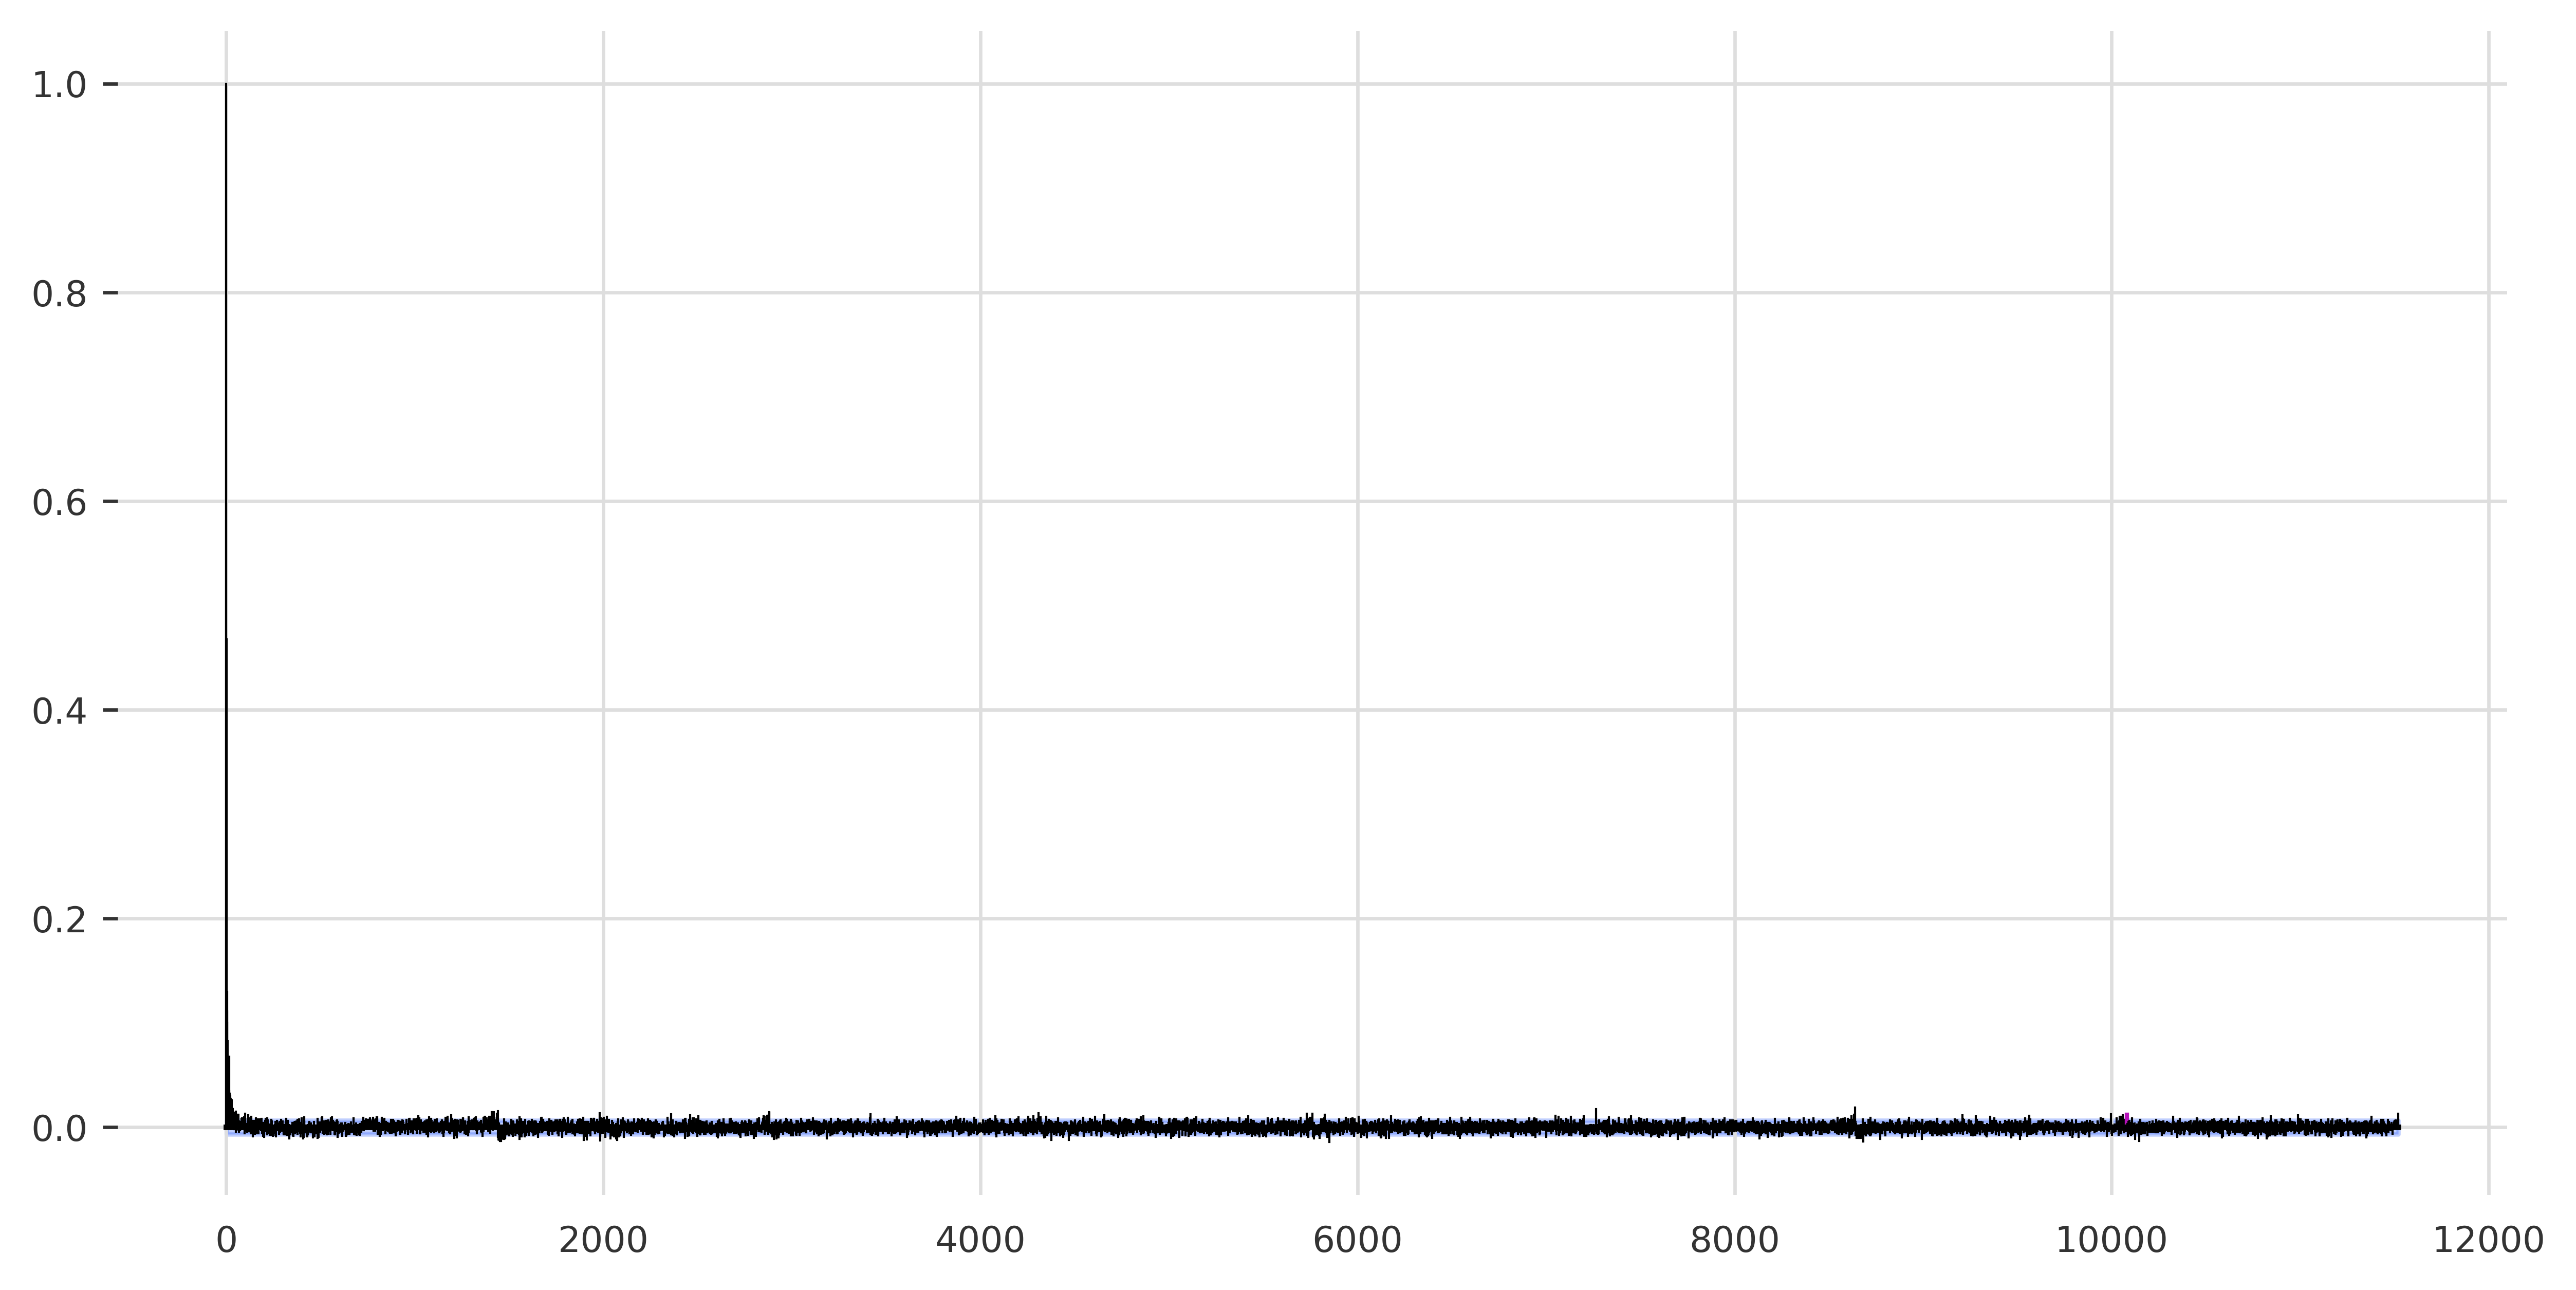

In [53]:
plot_pacf(dataset_min60, m=(24*60*7), max_lag=(24*60*8),alpha=0.05)

In [ ]:
check_seasonality(dataset_min60, m=(24*60), max_lag=(25*60))

In [121]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=120, output_chunk_length=20, random_state=42)

model.fit([train_min60], epochs=100, verbose=True)

[2022-06-18 12:04:17,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 7925 samples.
[2022-06-18 12:04:17,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 7925 samples.
2022-06-18 12:04:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 7925 samples.
[2022-06-18 12:04:17,724] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-18 12:04:17,724] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-18 12:04:17 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-18 12:04:17,726] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Training: 0it [00:00, ?it/s]

In [122]:
# save model
model.save_model('./models/train7day-split80%-input120-output20-seed42.pth.tar')

In [131]:
from darts.models import NBEATSModel
model = NBEATSModel.load_model(path='./models/train7day-split80%-input60-output20-seed42.pth.tar')

Predicting: 0it [00:00, ?it/s]

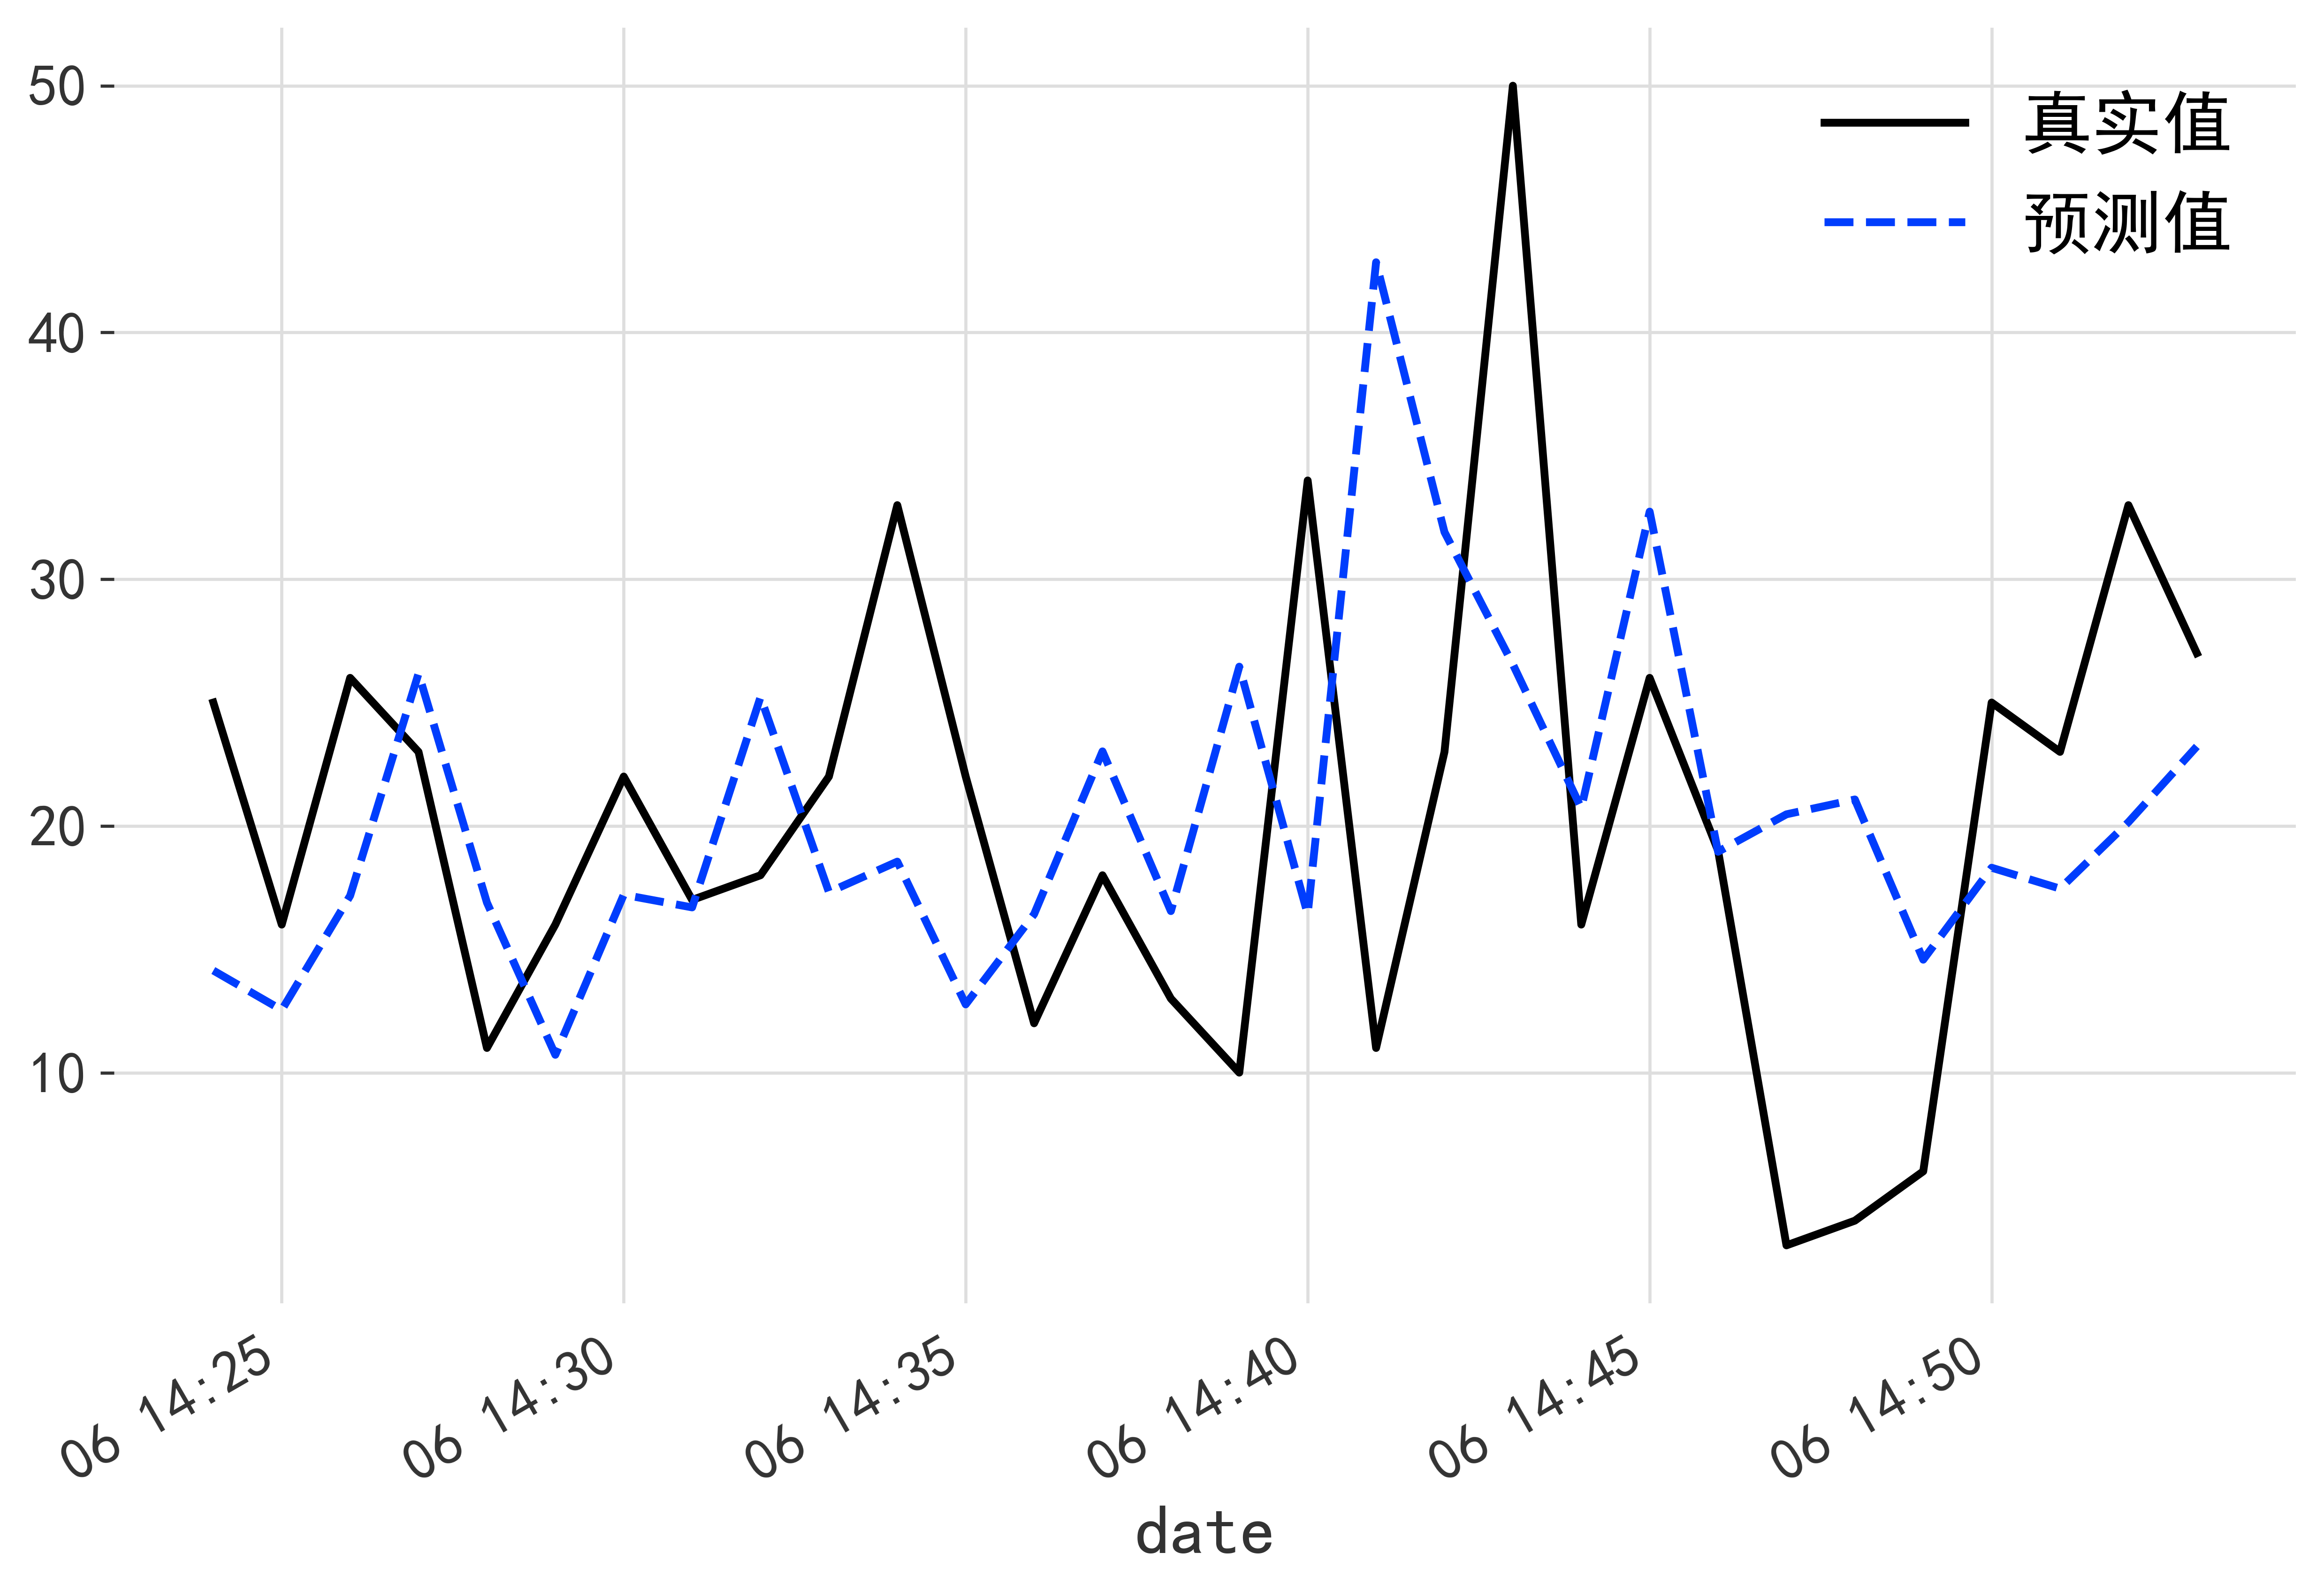

In [136]:
matplotlib.rcParams.update({"font.size": 18})
pred = model.predict(series=train_min60, n=30)
plt.figure(figsize=(10, 6))
val_min60.head(30).plot(label="真实值")
pred.plot(label="预测值", linestyle='--')

In [81]:
# 计算精确度
from darts.metrics.metrics import coefficient_of_variation
from darts.metrics.metrics import mape
from darts.metrics.metrics import r2_score

  0%|          | 0/1 [00:00<?, ?it/s]

mape = 37.1037


  0%|          | 0/1 [00:00<?, ?it/s]

r2 = -0.1027


  0%|          | 0/1 [00:00<?, ?it/s]

rmse = 46.6310


In [103]:
model2 = NBEATSModel(input_chunk_length=60, output_chunk_length=30, random_state=42)

model2.fit([train_min60], epochs=100, verbose=True)

[2022-06-17 20:50:16,008] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 7975 samples.
[2022-06-17 20:50:16,008] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 7975 samples.
2022-06-17 20:50:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 7975 samples.
[2022-06-17 20:50:16,128] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-17 20:50:16,128] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-17 20:50:16 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-17 20:50:16,130] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Light

Training: 0it [00:00, ?it/s]

Predicting: 250it [00:00, ?it/s]

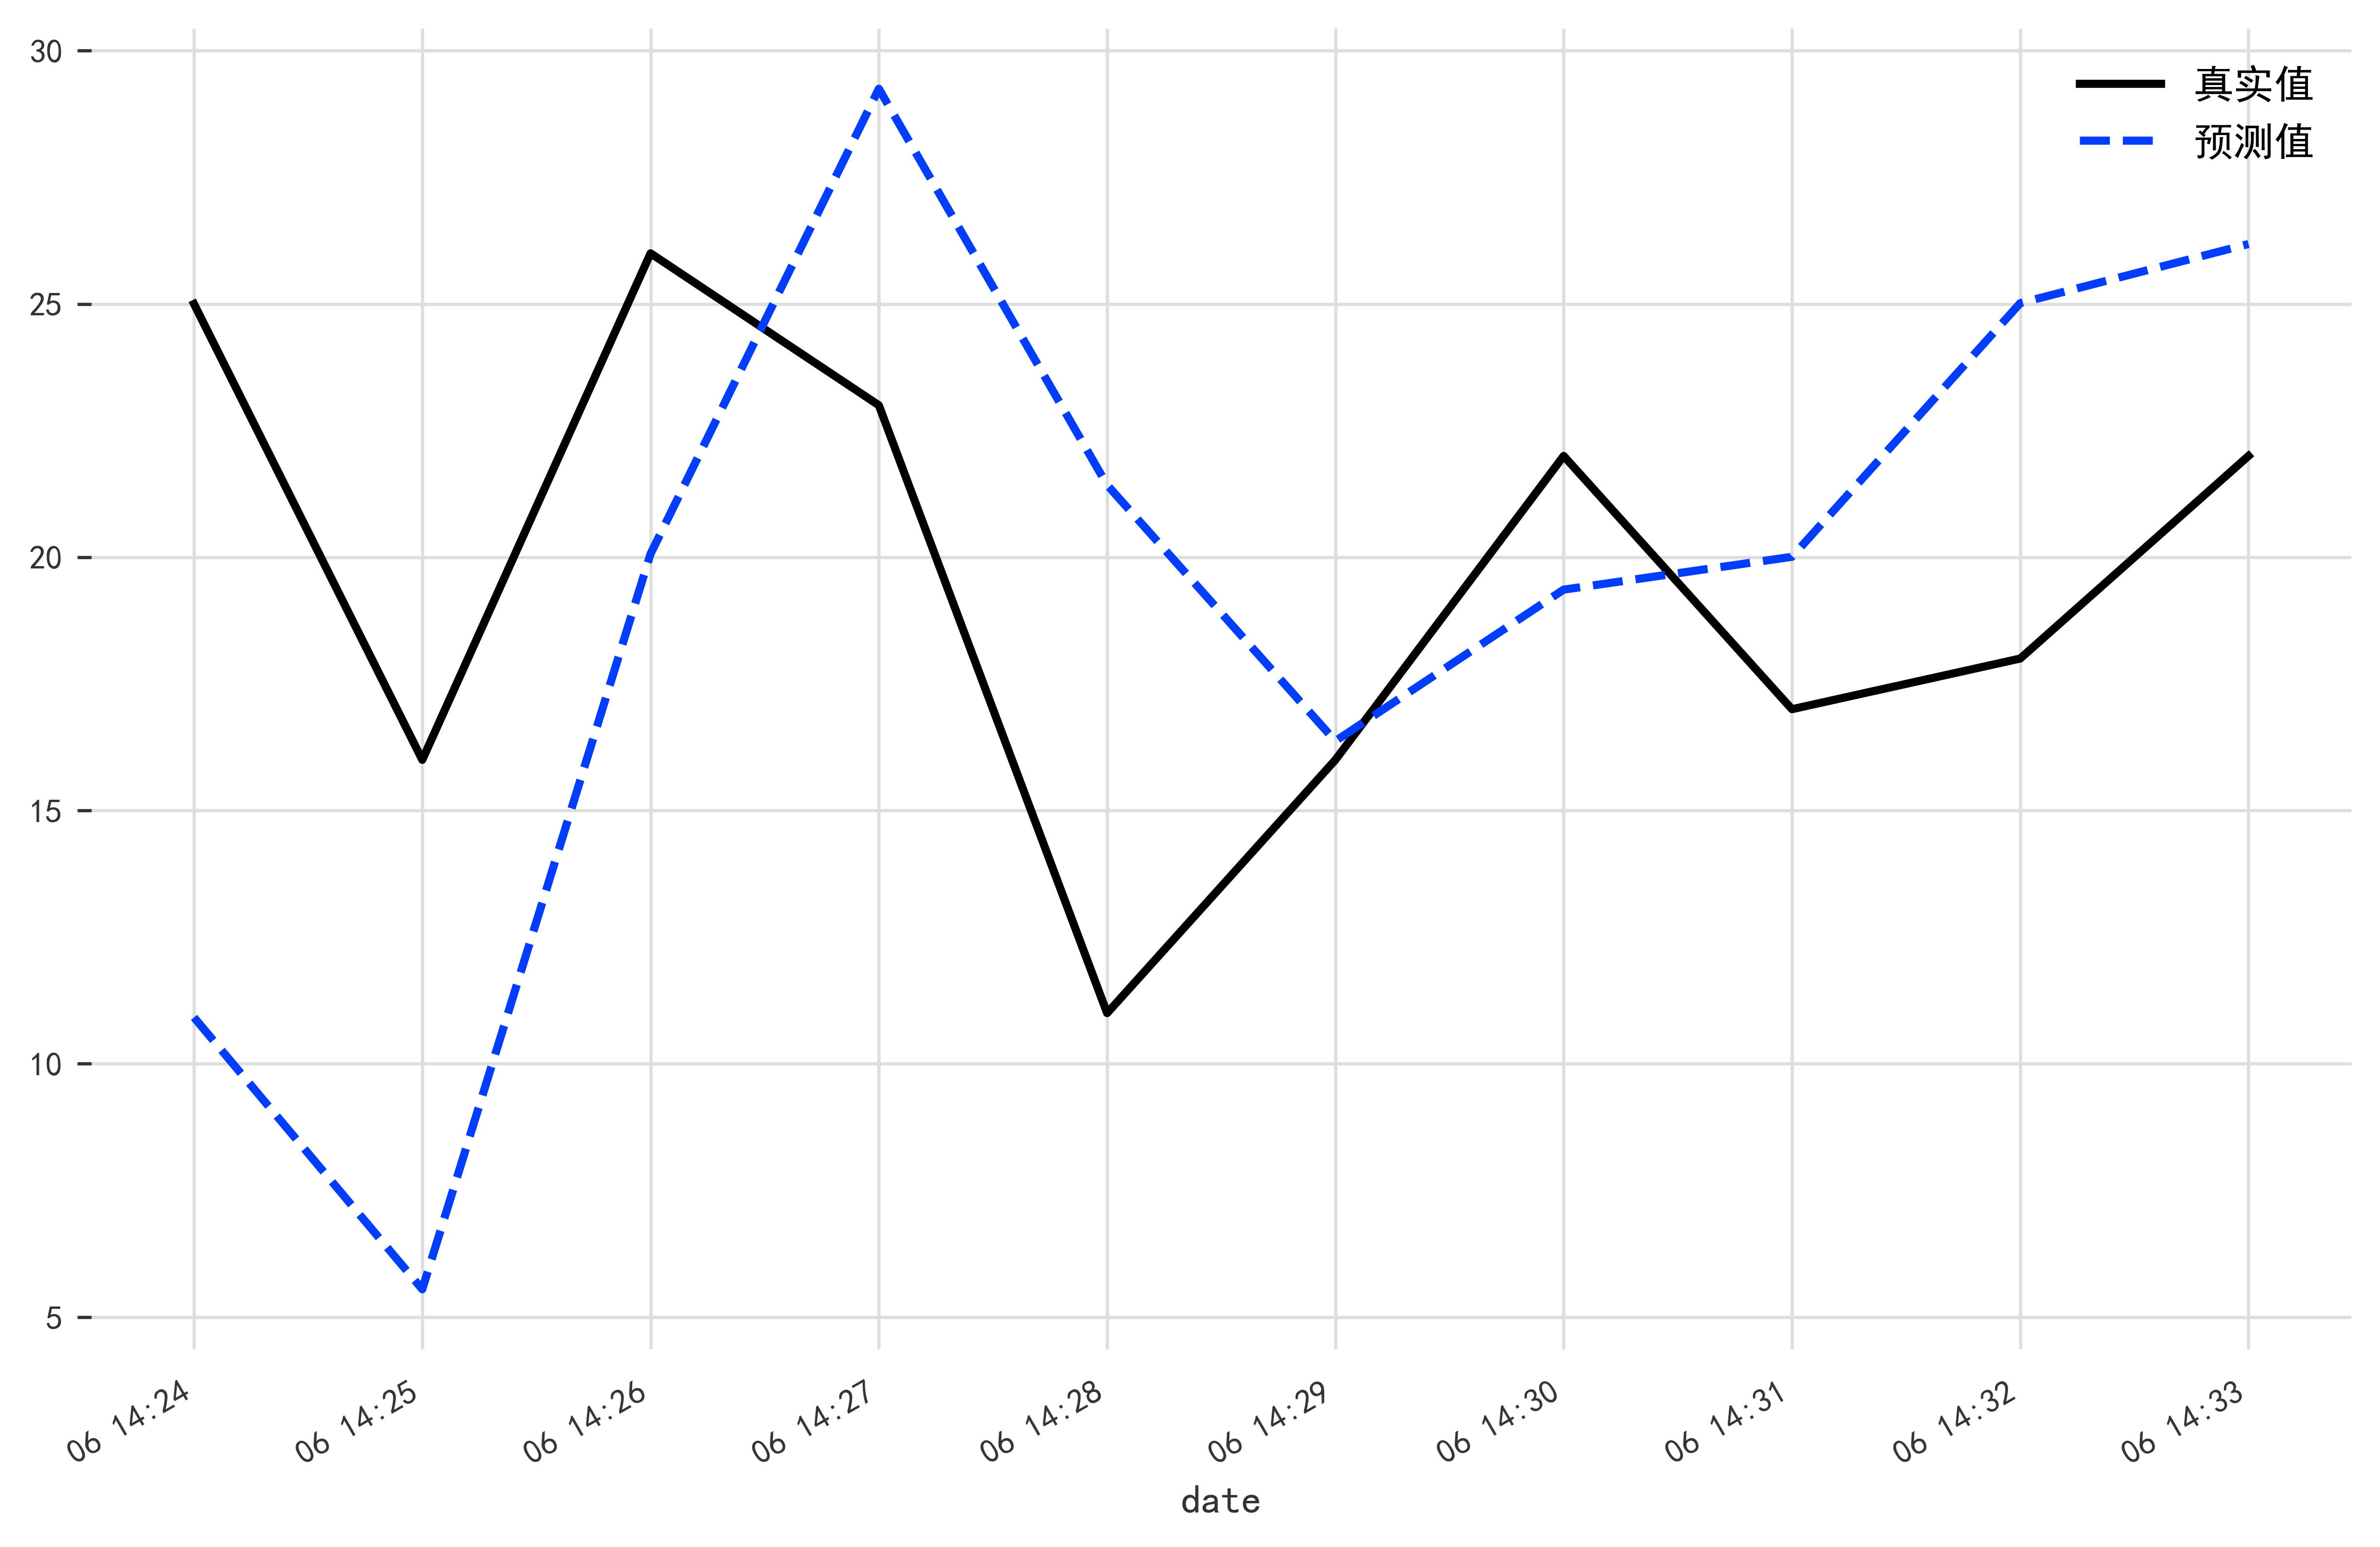

In [127]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'KaiTi', 'FangSong'] 
pred2 = model2.predict(series=train_min60, n=10)
plt.figure(figsize=(10, 6))
val_min60.head(10).plot(label="真实值")
pred2.plot(label="预测值", linestyle='--')

In [118]:
m = mape(val_min60.head(10), pred2, verbose=True)
print("mape = %.4f" % m)
r2 = r2_score(val_min60.head(10), pred2, verbose=True)
print("r2 = %.4f" % r2)
rmse = coefficient_of_variation(val_min60.head(10), pred2, verbose=True)
print("rmse = %.4f" % rmse)

  0%|          | 0/1 [00:00<?, ?it/s]

mape = 35.6448


  0%|          | 0/1 [00:00<?, ?it/s]

r2 = -1.8334


  0%|          | 0/1 [00:00<?, ?it/s]

rmse = 38.6369


In [120]:
# save model
model2.save_model('./models/train7day-split80%-input60-output30-seed42.pth.tar')